### PCA in Machine Learning Workflows
#### Machine Learning I - Maestría en Analítica Aplicada
#### Universidad de la Sabana
#### Prof: Hugo Franco
#### Example: SMOTE - Credit Card Fraud Classification

* Required step: install the module for imbalanced data processing: 

`conda install -c conda-forge imbalanced-learn`

## Jhon Rojas 
## Diego Suárez
## Giovanni Moreno

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

1. Load and describe the data 

Well-known credit card fraud dataset from Kaggle, locally loaded for this example. Confirm the class imbalance. 

In [2]:
# Load the dataset
df = pd.read_csv('creditcard.csv')

print (df.info())
# Check class distribution
print("Class Distribution:")
print(df['Class'].value_counts())
print("\nPercentage Distribution:")
print(df['Class'].value_counts(normalize=True) * 100)

# Non-Fraud (0): 99.827%
# Fraud (1):    0.173%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

2. Data Preparation

Following the best practices outlined in the lecture, we'll first scale the features and then split our data. The 

Time and Amount columns are not on the same scale as the anonymized 'V' features, so they need scaling.

In [3]:
# Scale 'Time' and 'Amount' features
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Define features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split Early, Split Once: Separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

3. Baseline Model: Training without SMOTE

How a standard model performs on the imbalanced data. This will serve as our baseline. As expected, the model will likely become biased towards the majority class.


In [4]:
# Train a simple Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred_baseline = model.predict(X_test)

# Evaluate the baseline model
print("--- Baseline Model Performance (Imbalanced Data) ---")
print(classification_report(y_test, y_pred_baseline, target_names=['Not Fraud', 'Fraud']))

# The recall for 'Fraud' will be very low, meaning the model misses most fraudulent transactions.
# This is a classic example of high False Negatives[cite: 100].

--- Baseline Model Performance (Imbalanced Data) ---
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56864
       Fraud       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



4. Apply SMOTE using a Pipeline to prevent data leakage, 

SMOTE must only be applied to the training data. Applying it before the train-test split would introduce synthetic data into our test set, leading to overly optimistic and invalid results. The best way to implement this is within a Scikit-learn Pipeline, as recommended in the slides.







In [5]:
# Create a pipeline that first applies SMOTE, then fits the model
# SMOTE will only be applied to the data fed to .fit(), i.e., the training data inside the CV loop
smote_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# Train the model using the pipeline
smote_pipeline.fit(X_train, y_train)

# Make predictions on the original, untouched test set
y_pred_smote = smote_pipeline.predict(X_test)

# Compute normalized confusion matrices
cm_baseline = confusion_matrix(y_test, y_pred_baseline, normalize='true')
cm_smote = confusion_matrix(y_test, y_pred_smote, normalize='true')

# Evaluate the model with SMOTE
print("\n--- Model Performance with SMOTE Pipeline ---")
print(classification_report(y_test, y_pred_smote, target_names=['Not Fraud', 'Fraud']))




--- Model Performance with SMOTE Pipeline ---
              precision    recall  f1-score   support

   Not Fraud       1.00      0.97      0.99     56864
       Fraud       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



5. Evalute results

Present the comparison between model perfomance using both imbalanced and balanced datasets

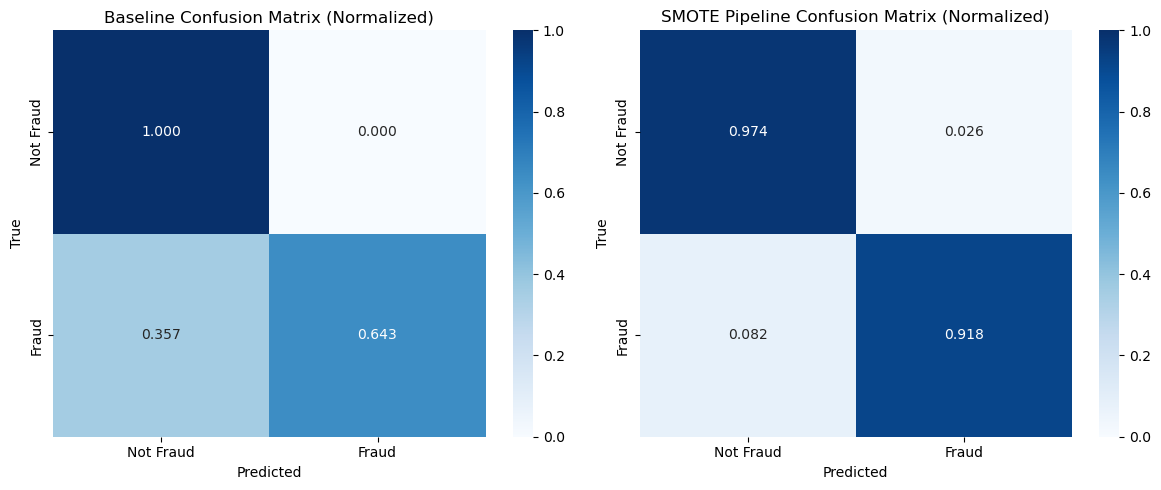

In [6]:
# Let's visualize the confusion matrices to see the difference
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot baseline confusion matrix
sns.heatmap(cm_baseline, annot=True, fmt='.3f', ax=axes[0], cmap='Blues', vmin=0, vmax=1)
axes[0].set_title('Baseline Confusion Matrix (Normalized)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Plot SMOTE confusion matrix
sns.heatmap(cm_smote, annot=True, fmt='.3f', ax=axes[1], cmap='Blues', vmin=0, vmax=1)
axes[1].set_title('SMOTE Pipeline Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Add class labels
class_names = ['Not Fraud', 'Fraud']
for ax in axes:
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

plt.tight_layout()
plt.show()

Entrenando Modelo Base (sin SMOTE)...
Entrenando Modelo con SMOTE (k=5)...
Entrenando Modelo con SMOTE (k=2)...
Entrenando Modelo con SMOTE (k=15)...

--- Reporte del Modelo Base ---
              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00     56864
      Fraude       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962


--- Reporte de SMOTE (k=5) ---
              precision    recall  f1-score   support

   No Fraude       1.00      0.97      0.99     56864
      Fraude       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


--- Reporte de SMOTE (k=2) ---
              precision    recall  f1-score   support

   No Fraude       1.00      0.97      0.99 

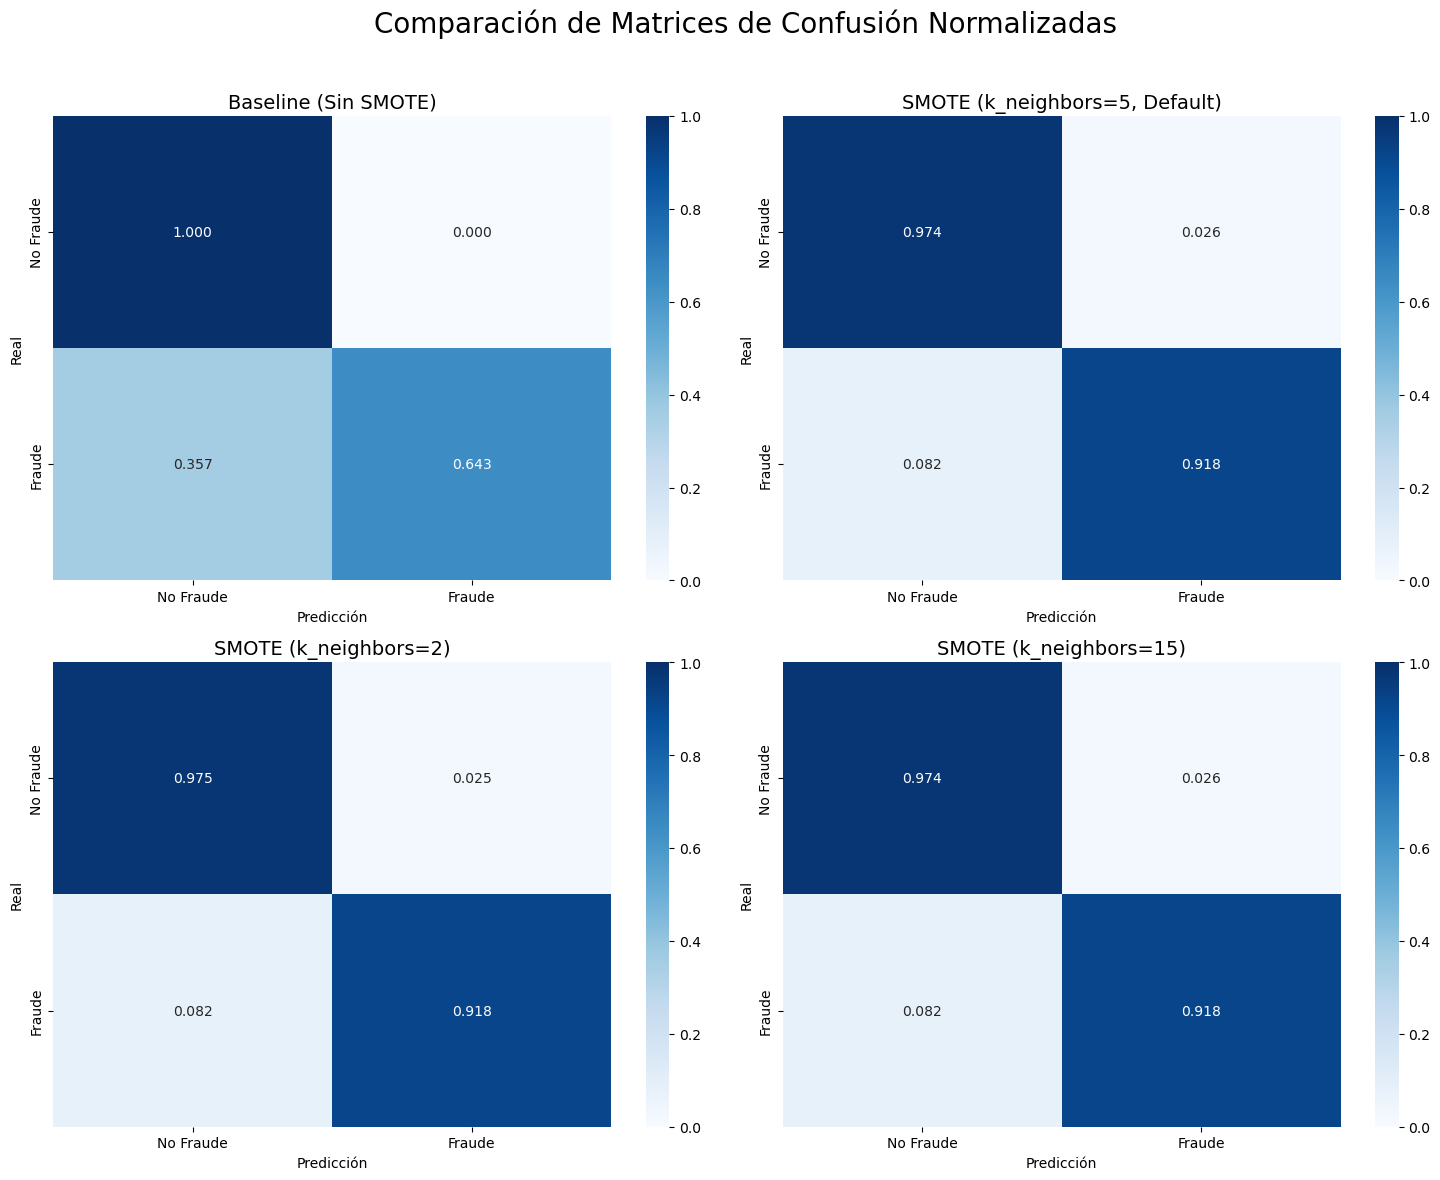

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# --- 1. Carga y Preparación de Datos ---
# Carga el dataset (asegúrate de que el archivo 'creditcard.csv' esté disponible)
try:
    df = pd.read_csv('creditcard.csv')
except FileNotFoundError:
    print("Error: El archivo 'creditcard.csv' no se encontró.")
    print("Por favor, asegúrate de que el archivo esté en el mismo directorio que el script.")
    exit()

# Escala las columnas 'Time' y 'Amount'
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Define las características (X) y el objetivo (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. Entrenamiento y Evaluación de los Modelos ---

# Escenario 1: Modelo Base (Sin SMOTE)
print("Entrenando Modelo Base (sin SMOTE)...")
model_baseline = LogisticRegression(random_state=42, max_iter=1000)
model_baseline.fit(X_train, y_train)
y_pred_baseline = model_baseline.predict(X_test)
cm_baseline = confusion_matrix(y_test, y_pred_baseline, normalize='true')
report_baseline = classification_report(y_test, y_pred_baseline, target_names=['No Fraude', 'Fraude'])

# Escenario 2: SMOTE con k_neighbors=5 (por defecto)
print("Entrenando Modelo con SMOTE (k=5)...")
pipeline_smote_default = Pipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=5)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])
pipeline_smote_default.fit(X_train, y_train)
y_pred_smote_default = pipeline_smote_default.predict(X_test)
cm_smote_default = confusion_matrix(y_test, y_pred_smote_default, normalize='true')
report_default = classification_report(y_test, y_pred_smote_default, target_names=['No Fraude', 'Fraude'])

# Escenario 3: SMOTE con k_neighbors=2 (menos vecinos)
print("Entrenando Modelo con SMOTE (k=2)...")
pipeline_smote_k2 = Pipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=2)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])
pipeline_smote_k2.fit(X_train, y_train)
y_pred_smote_k2 = pipeline_smote_k2.predict(X_test)
cm_smote_k2 = confusion_matrix(y_test, y_pred_smote_k2, normalize='true')
report_k2 = classification_report(y_test, y_pred_smote_k2, target_names=['No Fraude', 'Fraude'])

# Escenario 4: SMOTE con k_neighbors=15 (más vecinos)
print("Entrenando Modelo con SMOTE (k=15)...")
pipeline_smote_k15 = Pipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=15)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])
pipeline_smote_k15.fit(X_train, y_train)
y_pred_smote_k15 = pipeline_smote_k15.predict(X_test)
cm_smote_k15 = confusion_matrix(y_test, y_pred_smote_k15, normalize='true')
report_k15 = classification_report(y_test, y_pred_smote_k15, target_names=['No Fraude', 'Fraude'])

# Imprime los reportes de clasificación
print("\n" + "="*50)
print("--- Reporte del Modelo Base ---")
print(report_baseline)
print("\n--- Reporte de SMOTE (k=5) ---")
print(report_default)
print("\n--- Reporte de SMOTE (k=2) ---")
print(report_k2)
print("\n--- Reporte de SMOTE (k=15) ---")
print(report_k15)
print("="*50 + "\n")


# --- 3. Visualización de Resultados ---
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación de Matrices de Confusión Normalizadas', fontsize=20)
class_names = ['No Fraude', 'Fraude']

# Matriz del Modelo Base
sns.heatmap(cm_baseline, annot=True, fmt='.3f', ax=axes[0, 0], cmap='Blues', vmin=0, vmax=1)
axes[0, 0].set_title('Baseline (Sin SMOTE)', fontsize=14)
axes[0, 0].set_xlabel('Predicción')
axes[0, 0].set_ylabel('Real')
axes[0, 0].set_xticklabels(class_names)
axes[0, 0].set_yticklabels(class_names)

# Matriz de SMOTE con k=5
sns.heatmap(cm_smote_default, annot=True, fmt='.3f', ax=axes[0, 1], cmap='Blues', vmin=0, vmax=1)
axes[0, 1].set_title('SMOTE (k_neighbors=5, Default)', fontsize=14)
axes[0, 1].set_xlabel('Predicción')
axes[0, 1].set_ylabel('Real')
axes[0, 1].set_xticklabels(class_names)
axes[0, 1].set_yticklabels(class_names)

# Matriz de SMOTE con k=2
sns.heatmap(cm_smote_k2, annot=True, fmt='.3f', ax=axes[1, 0], cmap='Blues', vmin=0, vmax=1)
axes[1, 0].set_title('SMOTE (k_neighbors=2)', fontsize=14)
axes[1, 0].set_xlabel('Predicción')
axes[1, 0].set_ylabel('Real')
axes[1, 0].set_xticklabels(class_names)
axes[1, 0].set_yticklabels(class_names)

# Matriz de SMOTE con k=15
sns.heatmap(cm_smote_k15, annot=True, fmt='.3f', ax=axes[1, 1], cmap='Blues', vmin=0, vmax=1)
axes[1, 1].set_title('SMOTE (k_neighbors=15)', fontsize=14)
axes[1, 1].set_xlabel('Predicción')
axes[1, 1].set_ylabel('Real')
axes[1, 1].set_xticklabels(class_names)
axes[1, 1].set_yticklabels(class_names)

plt.tight_layout(rect=[0, 0, 1, 0.96])
# Guarda la figura en un archivo
plt.savefig('comparacion_matrices_confusion.png')

print("¡Análisis completo! La imagen 'comparacion_matrices_confusion.png' ha sido guardada.")